In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter("ignore")
from matplotlib import pyplot as plt

# Specify datafile
data_file = os.path.join('..', 'data', 'vegashrinker.csv')
# Read data
data = pd.read_csv(data_file)
# Define the input feature
feat_in_r = data.columns[[0, 6, 7, 9, 11, 12, 13]]
# Apply binning
aggmap = {a: ['mean', 'std', 'skew'] for a in feat_in_r}
aggmap['mode'] = 'first'
aggmap['pSpintor::VAX_speed'] = 'first'
binsize = 512 # 2 seconds of measurements
bins = []
for sname, sdata in data.groupby('segment'):
    sdata['bin'] = sdata.index // binsize # Build the bin numbers
    tmp = sdata.groupby('bin').agg(aggmap) # Apply the aggregation functions
    bins.append(tmp)
data_b = pd.concat(bins)

# Baseline Approach

## Train/Test Split

**We'll try to detect the component state by learning an autoencoder**

* We'll train a model on the earlier data
* ...And then use the reconstruction error as a proxy for component wear

**We start as usual by splitting the training and test set**

In [3]:
tr_sep = int(0.5 * len(data_b))
data_b_tr = data_b.iloc[:tr_sep]
data_b_ts = data_b.iloc[tr_sep:]

...And then by standardizing our data

In [4]:
scaler = StandardScaler()
data_b_s_tr = scaler.fit_transform(data_b_tr)
data_b_s_ts = scaler.transform(data_b_ts)
data_b_s = pd.DataFrame(columns=data_b.columns, data=np.vstack([data_b_s_tr, data_b_s_ts]))

## Training and Autoencoder

**Now we can build and train the autoencoder**

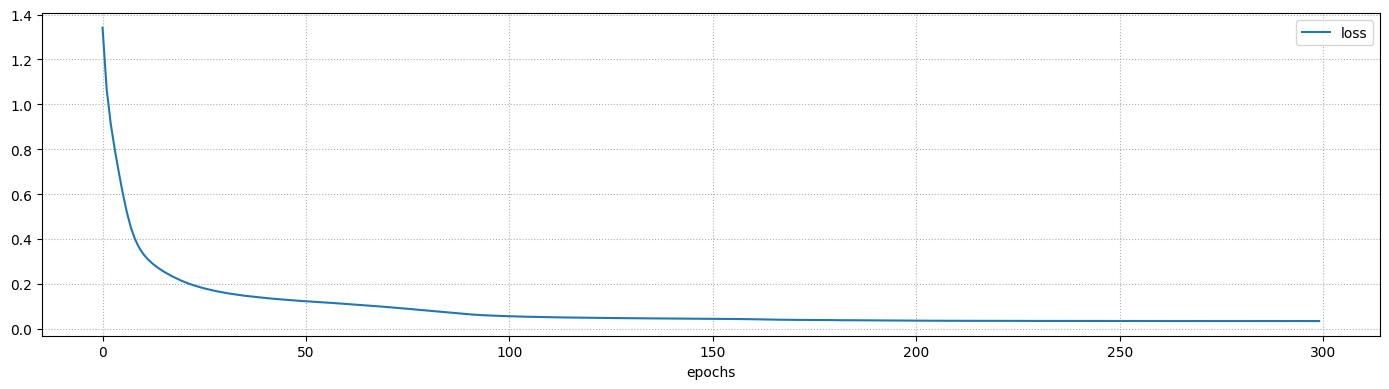

Final loss: 0.0346 (training)


In [13]:
nn = util.build_nn_model(input_shape=len(data_b.columns), output_shape=len(data_b.columns),
                         hidden=[len(data_b.columns)//2])
history = util.train_nn_model(nn, data_b_s_tr, data_b_s_tr, loss='mse', validation_split=0.0,
                              batch_size=32, epochs=300)
util.plot_training_history(history, figsize=figsize)

* We need many epochs to compensate for the small number of samples

## Evaluation

**Let's check the reconstruction error**

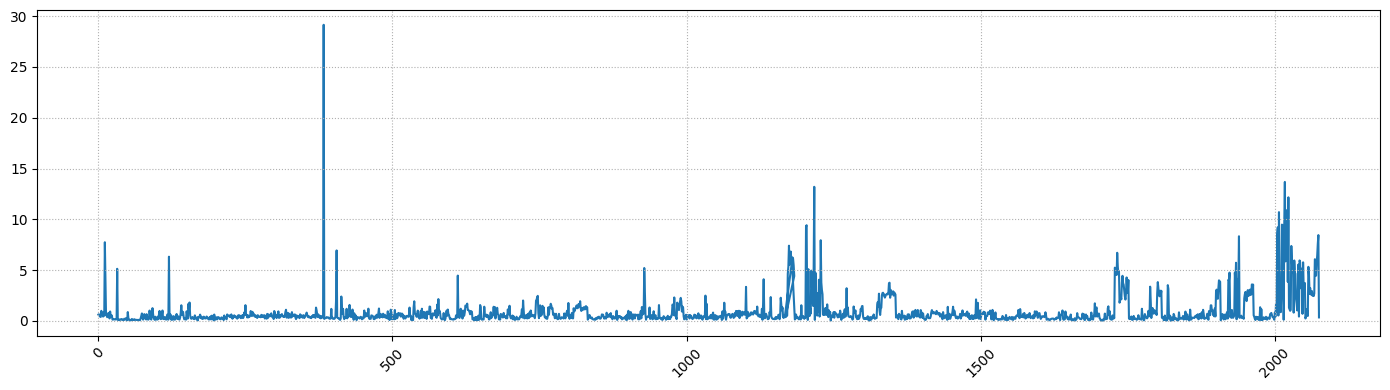

In [14]:
pred = nn.predict(data_b_s, verbose=0)
se = (data_b_s - pred)**2
sse = pd.Series(index=data_b.index, data=np.sum(se, axis=1))
util.plot_series(sse, figsize=figsize)

* Since we have a single run, we will limit ourselves to a visual inspection
* ...And the signal does not look very clear

## Evaluation

**We can gain more information by checking the individual errors**

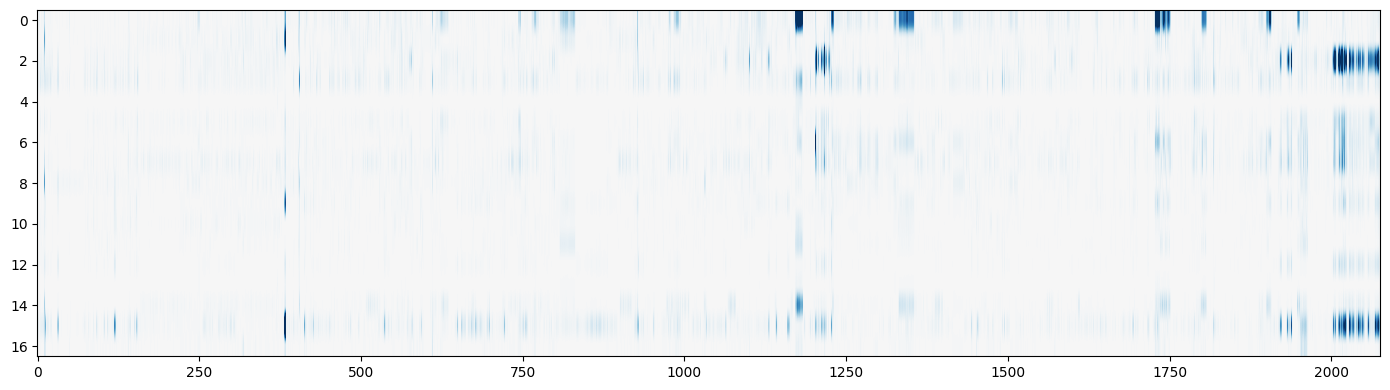

In [15]:
util.plot_dataframe(se, figsize=figsize)

* Reconstruction errors are large for different features over time

<div class=big>Do you think we can improve these results? How?</div>

# Altering the Training Distribution

## Distribution Discrepancy

**A major problem is related to the distribution balance**

The modes of operation are _not used equally often_

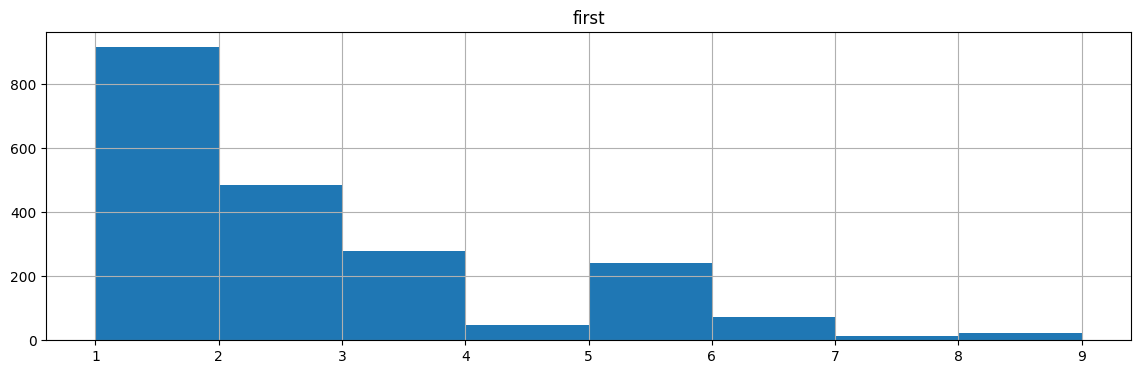

In [16]:
data_b['mode'].hist(figsize=figsize, bins=np.arange(1, 10));

* Moreover, the mode of operation is a _controlled variable_
* ...Therefore there is no guarantee that it's distribution is stable 

## Distribution Discrepancy

**In fact, there is a difference between the training and test distribution**

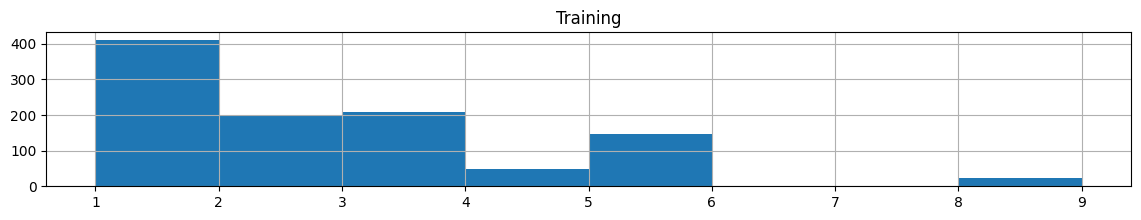

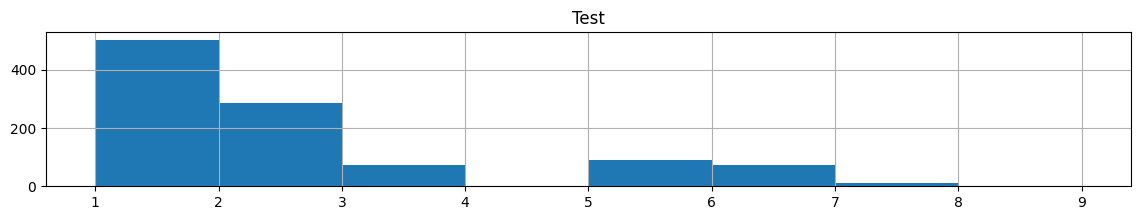

In [17]:
data_b_tr['mode'].hist(figsize=(figsize[0], figsize[1]/2), bins=np.arange(1, 10)); plt.title('Training');
data_b_ts['mode'].hist(figsize=(figsize[0], figsize[1]/2), bins=np.arange(1, 10)); plt.title('Test');

## Maximum Likelihood

**This matters because we are _training for maximum likelihood_**

...Ideally we would like to solve:

$$
\mathop{\text{argmax}}_{\theta} \mathbb{E}_{\hat{x}, \hat{y} \sim P}\left[ \prod_{i=1}^m f_\theta(\hat{y}_i \mid \hat{x}_i) \right]
$$

* $P$ represents the real (joint) distribution
* $f_\theta(\cdot \mid \cdot)$ is our model, with parameter vector $\theta$
* I.e. an estimator for a conditional distribution
* We distinguish $\hat{x}$ (input) and $\hat{y}$ (output) to cover generic supervised learning
* ...Even if for an autoencoder they are the same

## ...And Empirical Risk

**...But in practive we don't have access to the full distribution**

So we use Monte-Carlo approximation:

$$
\mathop{\text{argmax}}_{\theta} \prod_{i=1}^m f_\theta(\hat{y}_i \mid \hat{x}_i)
$$

* Typically, we consider _a single sample_ $\hat{x}, \hat{y}$ (i.e. the _training set_)
* The resulting objective (i.e. the big product) is sometimes called _empirical risk_

This the usual training approach with most ML models, and it mostly works

**Problems arise when _our sample is biased_.** E.g. because:

* We can collect data only under certain circumstances
* The dataset is the result of a selection process
* ...Or perhaps due to pure sampling noise

## Handling Sampling Noise

**So, let's recap**

* Our problem is that the training sample is biased
* ...So that it is _not representative_ of the true distribution

> **How can we deal with this problem?**

* A possible solution would be to _alter the training distribution_
* ...So that it _matches more closely_ the test distribution

**...And this is actually something we can do!**

* E.g. we can use data augmentation
* ...Or we can use _sample weights_

## Handling Sampling Noise with Sample Weights

**Let our training set consist of $\{(\hat{x}_1, \hat{y}_1), (\hat{x}_2, \hat{y}_2)\}$**

The corresponding optimization problem would be:

$$
\mathop{\text{argmax}}_{\theta} f_\theta(\hat{y}_1 \mid \hat{x}_1) f_\theta(\hat{y}_2 \mid \hat{x}_2)
$$

Let's pretend that sample \#2 occurs twice; that would lead to:

$$
\mathop{\text{argmax}}_{\theta} f_\theta(\hat{y}_1 \mid \hat{x}_1) f_\theta(\hat{y}_2 \mid \hat{x}_2)^2
$$

**In general, _multiplicities_ show up as _exponents_ in the training objective**

$$
\mathop{\text{argmax}}_{\theta} \prod_{i=1}^m f_\theta(\hat{y}_i \mid \hat{x}_i)^{n_i}
$$

* The approach works even for fractional $n_i$ values

## Handling Sampling Noise with Sample Weights

**We can use this insight to _simulate a different distribution_**

* In particular, assuming that $\tilde{p}_i$ is the true probability of sample $i$
* ...And that $\hat{p}_i$ is its probability in the training set

...Then we can simulate a training distribution _closer to the true one_ by solving:

$$
\mathop{\text{argmax}}_{\theta} \prod_{i=1}^m f_\theta(\hat{y}_i \mid \hat{x}_i)^{\tilde{p}_i / \hat{p}_i}
$$

**Switching to log scale (and minimization), we end up with _sample weights_**

$$
\mathop{\text{argmin}}_{\theta} - \sum_{i=1}^m \frac{\tilde{p}_i}{\hat{p}_i} \log f_\theta(\hat{y}_i \mid \hat{x}_i)
$$

* We are still limited to examples in the training set, but this is a big improvement

## Handling Sampling Noise with Sample Weights

**The tricky part is making a good assumption about $\tilde{p}$**

* A common one is just _neutralizing sampling bias_
* In practice, we assume $\tilde{p}_i = 1, \forall i = 1..m$
* ...And we compute $\hat{p}_i$ based on the training data

**This is called _inverse probability weighting_**

For example, if we are afraid some _classes_ are under-represented

* ...Then we make $\hat{p}_i = $ the frequency of the class for example $i$
* ...Which is of course the typical "class rebalancing trick"

**But this is a general rule and we can do much more!**

## Handling Sampling Noise with Sample Weights

**First, we are _not limited to classes_**

* If we are afraid some _operating modes_ are under-represented
* ...Then we make $\hat{p}_i = $ the frequency of the mode for example $i$

**Second, we can exploit information about the test distribution**

* If we can make reasonable assumptions about our $\tilde{p}_i$
* ...Then we know how to update the weights to take that into account

**Third, we can deal with _selection bias_**

* E.g. consider the problem of estimating success rates for organ transplants
* Subject in the training set will obviously not be chosen at random
* If we can estimate their _selection probabilities $\hat{p}_i$_ (e.g. via another classifier)
* ...Then we can mitigate the bias effect using sample weights

## Handling Sampling Noise with Sample Weights

**Fourth: we can handle bias over _continuous attributes_ (e.g. income)**

* Then we can compute $\hat{p}_i$ using (e.g.) a _density estimator_
* ...Or any other model capably of producing a probability as output

**Just beware of overly large/small densities**

...Since they will break havoc in numerical optimization algorithms

* Patch 1: apply (lower/upper) clipping to densities
* Patch 2: normalize densities over the training set (make them sum up to 1)

> **This means we can cancel (sampling) bias based on _any kind of attribute_**

## Handling Sampling Noise with Sample Weights

**There's a final notable case in case our _loss is the MSE_**

In this case we have proved the training problem is equivalent to:

$$
\mathop{\text{argmin}}_{\theta} - \sum_{i=1}^m \log k \exp\left(-\frac{1}{2}(\hat{y}_i - h_\theta(\hat{x}_i))^2\right)
$$

* We have simply replaced the generic PDF with a Normal one
* We have $k = 1/\sqrt{2\pi}$ to simplify the notation

**Let's now introduce sample weights, in the form as $1/\hat{\sigma}_i^2$**

By doing so we get:

$$
\mathop{\text{argmin}}_{\theta} - \sum_{i=1}^m \frac{1}{\hat{\sigma}_i^2} \log k \exp\left(-\frac{1}{2}(\hat{y}_i - h_\theta(\hat{x}_i))^2\right)
$$


## Handling Sampling Noise with Sample Weights

**Which can be rewritten as:**

$$
\mathop{\text{argmin}}_{\theta} - \sum_{i=1}^m \log k \exp\left(-\frac{1}{2}\left(\frac{\hat{y}_i - h_\theta(\hat{x}_i}{\hat{\sigma}_i^2}\right)^2\right)
$$

* This means that sample weights with an MSE loss
* ...Can be interpreted as _inverse sample variances_

**This gives us a way to account for _measurement errors_**

* If we know that there is a measurment error with stdev $\hat{\sigma}_i$ on example $i$
* ...We can account for that by using $1/\hat{\sigma}_i^2$ as a weight

The result is analogous to using a separate variance model

## Canceling Sampling Bias in Our Problem

**Let's apply the approach to our skinwrapper example**

* In our case, we observed there is a bias linked to operating modes
* We do not know the "true" distribution
* ...But is reasonable to try and be fair w.r.t. any operating mode

**So we can open for the inverse probability weighting approach**

First, we compute the inverse mode frequencies:

In [18]:
vcounts = data_b_tr['mode', 'first'].value_counts()
mode_weight = vcounts.sum() / vcounts

Then we compute the weight for each example:

In [19]:
sample_weight = mode_weight[data_b_tr['mode', 'first']]

## Training with Sample Weights

**Now we can pass training weights to the training algorithm**

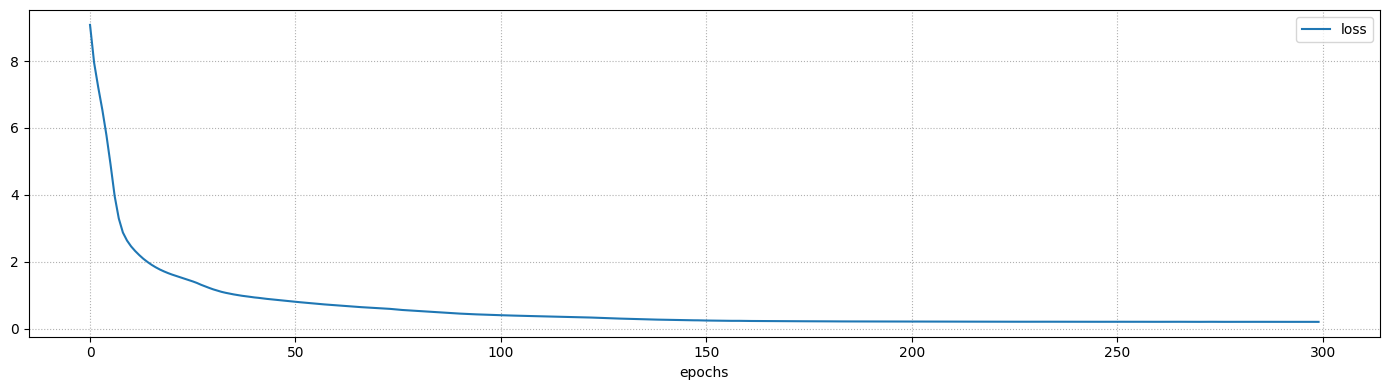

Final loss: 0.2040 (training)


In [20]:
nn2 = util.build_nn_model(input_shape=len(data_b.columns), output_shape=len(data_b.columns), hidden=[len(data_b.columns)//2])
history = util.train_nn_model(nn2, data_b_s_tr, data_b_s_tr, loss='mse', validation_split=0.0, batch_size=32, epochs=300, sample_weight=sample_weight)
util.plot_training_history(history, figsize=figsize)

## Evaluation

**Let's check the new reconstruction error**

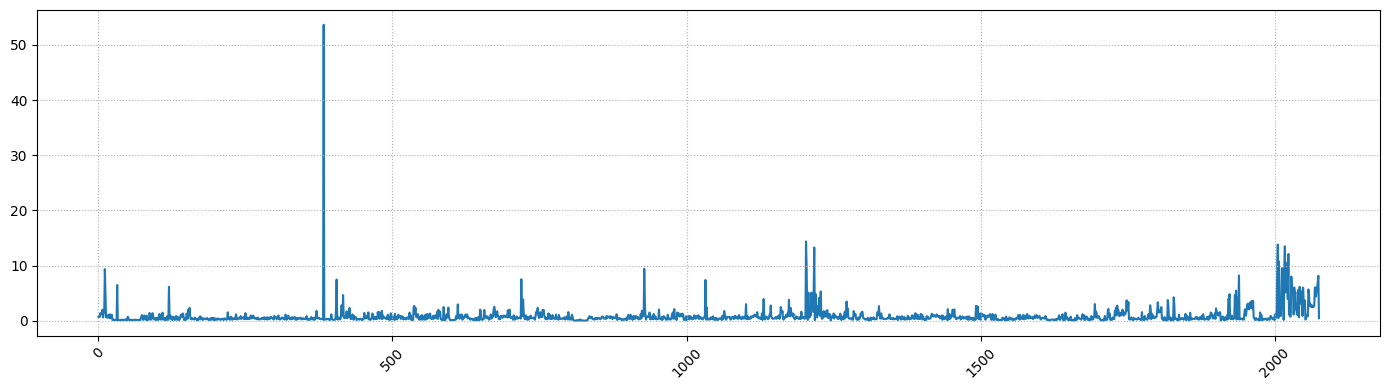

In [21]:
pred2 = nn2.predict(data_b_s, verbose=0)
se2 = (data_b_s - pred2)**2
sse2 = pd.Series(index=data_b.index, data=np.sum(se2, axis=1))
util.plot_series(sse2, figsize=figsize)

An intermediate peak has disappeared

## Evaluation

**...And the individual error components are very different**

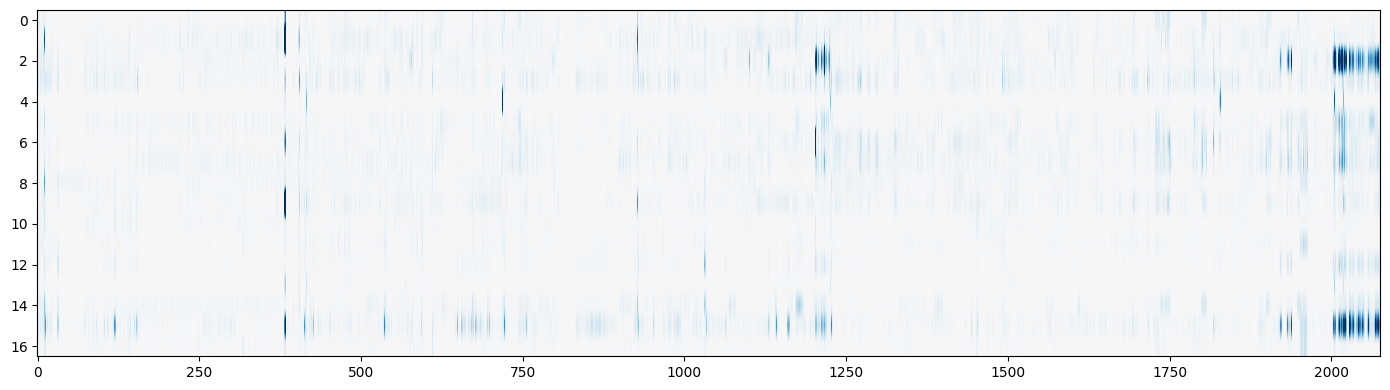

In [22]:
util.plot_dataframe(se2, figsize=figsize)

Now there is a much clearer plateau close to the end of the run